Assignment-04

# . 复习上课内容以及复现课程代码

In [86]:
%matplotlib inline
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt

##  课堂代码

In [27]:
import numpy as np


class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None

        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):

        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N


class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):

        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.



class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [28]:
from sklearn.datasets import load_boston

In [29]:
data= load_boston()
print(type(data), data.keys())


<class 'sklearn.utils.Bunch'> dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


"""
Check out the new network architecture and dataset!

Notice that the weights and biases are generated randomly.

No need to change anything, but feel free to tweak

to test your network, play around with the epochs, batch size, etc!
"""

In [30]:
epochs = 5000
n_hidden = 10

In [31]:
losses = []

import numpy as np
from sklearn.utils import shuffle, resample

data = load_boston()
X_ = data['data']
y_ = data['target']


# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 182.282
Epoch: 101, Loss: 6.926
Epoch: 201, Loss: 5.854
Epoch: 301, Loss: 4.847
Epoch: 401, Loss: 5.574
Epoch: 501, Loss: 5.057
Epoch: 601, Loss: 3.625
Epoch: 701, Loss: 4.487
Epoch: 801, Loss: 3.871
Epoch: 901, Loss: 3.609
Epoch: 1001, Loss: 4.240
Epoch: 1101, Loss: 4.050
Epoch: 1201, Loss: 3.996
Epoch: 1301, Loss: 3.685
Epoch: 1401, Loss: 4.776
Epoch: 1501, Loss: 4.095
Epoch: 1601, Loss: 4.077
Epoch: 1701, Loss: 3.754
Epoch: 1801, Loss: 4.016
Epoch: 1901, Loss: 4.272
Epoch: 2001, Loss: 3.484
Epoch: 2101, Loss: 4.105
Epoch: 2201, Loss: 4.143
Epoch: 2301, Loss: 4.041
Epoch: 2401, Loss: 3.459
Epoch: 2501, Loss: 3.238
Epoch: 2601, Loss: 3.601
Epoch: 2701, Loss: 4.017
Epoch: 2801, Loss: 3.733
Epoch: 2901, Loss: 3.907
Epoch: 3001, Loss: 3.851
Epoch: 3101, Loss: 4.317
Epoch: 3201, Loss: 3.068
Epoch: 3301, Loss: 3.740
Epoch: 3401, Loss: 3.795
Epoch: 3501, Loss: 3.487
Epoch: 3601, Loss: 3.978
Epoch: 3701, Loss: 4.165
Epoch: 3801, Loss: 4.103
Epoc

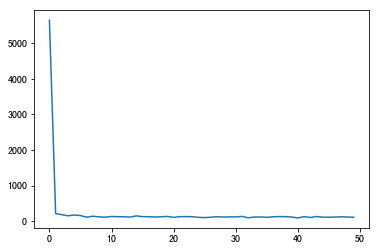

In [32]:
import matplotlib.pyplot as plt

plt.plot(range(len(losses)), losses)

In [33]:
W2.value

array([[ 5.82318386],
       [ 3.86922848],
       [ 9.34185796],
       [-4.04553477],
       [ 2.9117156 ],
       [ 4.9552698 ],
       [ 5.87589513],
       [12.57094081],
       [10.25077736],
       [ 9.31309672]])

In [21]:
import tensorflow as tf

In [47]:
X_[0]

array([-0.41978194,  0.28482986, -1.2879095 , -0.27259857, -0.14421743,
        0.41367189, -0.12001342,  0.1402136 , -0.98284286, -0.66660821,
       -1.45900038,  0.44105193, -1.0755623 ])

##  tensorflow 实现

In [117]:
#迭代次数
train_epochs = 500
#学习率
learning_rate = 0.01
# 打印结果
print_grap = 10

In [120]:
# 准备好placeholder
x = tf.placeholder(tf.float32,[None,13],name="X")
y = tf.placeholder(tf.float32,[None, 1],name="Y")

# 初始化参数/权重
W = tf.Variable(tf.random_normal([13,1],stddev=0.01), name='weight')
b = tf.Variable(1.0, name='bias')# 初始化参数/权重

# b = tf.Variable(tf.random_normal([]), name='bias')# 初始化参数/权重

#创建一个简单的神经网络
prediction = tf.matmul(x,W)+b

#二次代价函数 :MSE
loss = tf.reduce_mean(tf.square(y-prediction))
#使用梯度下降法
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

#初始化变量
init = tf.global_variables_initializer()

losses_tf = []

#train
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(train_epochs):
        
        loss_sum = 0.0
        
        for xs, ys in zip(X_, y_):
            xs = xs.reshape(1,13)
            ys = ys.reshape(1,1)
            _, loss_epocch = sess.run([train_step, loss],feed_dict={x:xs,y:ys})
            loss_sum += loss_epocch
            
        # 完成一次更新就 打乱数据顺序
        X_, y_ = shuffle(X_, y_)
        b_temp = b.eval(session = sess)
        W_temp = W.eval(session=sess)
        
        loss_average = loss_sum / X_.shape[0]
        
#         losses_tf.append(loss_average)
        
        if epoch % print_grap == 0:
            losses_tf.append(loss_average)
#             print("epoch=",epoch+1,"loss(MSE)=",loss_average,"b=",b_temp,"w=",W_temp)
        

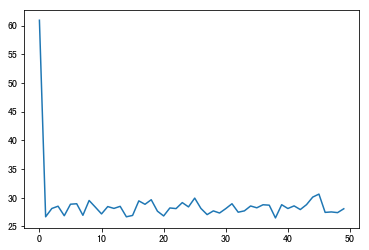

In [121]:
plt.plot(range(len(losses_tf)), losses_tf)

In [65]:
! pip install keras

In [25]:
from keras.layers import Dense
from keras.models import Sequential

Using TensorFlow backend.


AttributeError: module 'tensorflow.python.keras.backend' has no attribute 'get_graph'

In [19]:
model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])

NameError: name 'Sequential' is not defined

In [ ]:
model.fit(X_, y_, epochs=5000, batch_size=32)

# . 回答一下理论题目

## What does a neuron compute?

ans:

## Why we use non-linear activation funcitons in neural networks?

ans: 如果是线性的激活函数，那么后面所有的层的导数都是一样的，这样的话就再多的层次也和一层是一样的效果

## What is the 'Logistic Loss' ?

$$loss=-\frac{1}{(n)}\sum [y*log \hat{y}+(1-y)log(1-\hat{y})]$$

## Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer ?

A. ReLU

B. Leaky ReLU

C. sigmoid

D. tanh

ans: C sigmoid 

## Why we don't use zero initialization for all parameters ?

ans:如果初始化成0，使得更新之后的不同节点的参数相同，不管进行多少轮的正向传播和反向传播，所有节点得到的参数都一样！因此，神经网络就失去了其特征学习的能力

## Can you implement the softmax function using python ?

In [2]:
def softmaax(array):
    array -= max(array)
    return np.exp(array) / sum(np.exp(array))

# .实践题

## 数据探索

In [71]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

In this practical part, you will build a simple digits recognizer to check if the digit in the image is larger than 5. This assignmnet will guide you step by step to finish your first small project in this course .

2 -  Overvie of the dataset

>- a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
- a test set contains m_test images labels as if the digit < 5 or 1 if the digit >= 5
- eah image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)


In [75]:
digits = datasets.load_digits()
print(type(digits), digits.keys())

<class 'sklearn.utils.Bunch'> dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


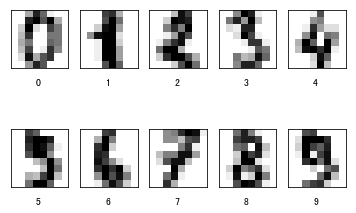

In [76]:
# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()  

In [77]:
# Split the data into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

In [78]:
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.

y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

In [79]:
print(c.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1347, 64)
(450, 64)
(1347,)
(450,)


##  Architecture of the neural network

Mathematical expression of the algorithm:
for one example $x^{(i)}$

$$z^{(i)} = w^{T} * x^{(i)} + b$$

$$y^{(i)} = a^{(i)}=sigmoid(z^{(i)})$$

$$L(a^{(i)},y^{(i)}) = -y^{(i)}log(a^{(i)}) - (1-y^{(i)})log(1-a^{(i)})$$

the total cost over all training examples:

$$J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)})$$

## Building the algorithm

### Activation function

In [83]:
def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: z -- a scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    '''
    
    return 1.0/(1 + np.exp(-1 * z))
print(sigmoid(2))
print(sigmoid(np.array([1,4,8])))

0.8807970779778823
[0.73105858 0.98201379 0.99966465]


In [84]:
# Test your code 
# The result should be [0.5 0.88079708]
print("sigmoid([0,2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0,2]) = [0.5        0.88079708]


### Initializaing parameters

In [100]:
# Random innitialize the parameters
def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector
    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    
    w = np.random.uniform(0.0,0.5,[dim,1])
    b = np.random.uniform(0.0,0.5,1)[0]
    print(w.shape,type(b),b)
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b

In [101]:
# Test your code 
# The result should be [0.5 0.88079708]
weight, b = initialize_parameters(3)
print(f"weitght: {weight}","\n", f"bias: {b}")

(3, 1) <class 'numpy.float64'> 0.24060630077173423
weitght: [[0.05561277]
 [0.24725275]
 [0.28474621]] 
 bias: 0.24060630077173423


### Forward and backward propagation

mathematical expressions

Forward Propagation:

$X$

$A = \sigma(w^{T} * X + b)=(a^{(1)},a^{(2)},a^{(3)} ...,a^{(m)})$

$J = \frac{-1}{m}\sum_{i=1}^{m}[y^{i}log(a^{(i)})+(1 - y^{(i)})log(1 - a^{(i)})]$

some derivative:

$$\frac{\partial J}{\partial w} = \frac{1}{m}X * (A - Y)^{T}$$

$$\frac{\partial J}{\partial b} =\frac{1}{m}\sum_{i=1}^{m}(a^{(i)} - y^{(i)})$$

In [104]:
np.array([[1,2],[3,4]])

array([[1, 2],
       [3, 4]])

In [116]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    """
    
    m = X.shape[1]
    A = [sigmoid(np.dot(w.T, X_i) + b) for X_i in X]
    cost = -1 * sum([y_i * np.log(a_i)+(1 - y_i)*np.log(1 - a_i) for a_i,y_i in zip(A,y)]) / m 

    
    dw = X * (A - Y).T / m
    db = sum([a_i - y_i for a_i,y_i in zip(A, Y)])
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

### Optimization

minimizing the cost function using gradient descent

$$\theta = \theta - \alpha * d\theta$$

where $\alpha$ is the learning rate

#### optimize

In [140]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w -= learning_rate * dw
        b -= learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    
    return params, grads, costs

#### predict

The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function.
Two steps to finish this task:

>1. Calculate $\hat{Y} = A = \sigma(w^T*X+b)$

>2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [141]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    
    A = [sigmoid(np.dot(w.T, X_i) + b) for X_i in X]
    
    for i in range(A.shape[1]):
        Y_prediction[i] = 0 if A[i] < 5 else 1  
    
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

### Merge all functions into a model

Congratulations !! You have finished all the necessary components for constructing a model. Now, Let's take the challenge to merge all the implemented function into one model.

In [142]:
def accuracy(y_true,y_hat):
    """计算准确率
    """
    temp = [ 1 if y_hat_i == y_i else 0 for y_hat_i,y_i in zip(y_hat,y_true)]
    
    return sum(np.array(temp))/len(y_true)

In [143]:

def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate,print_cost):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    d = {"w":None, "b":None, "training_accuracy":None, "test_accuracy":None, "cost":None}
    
    # 初始化 W,B
    w,b = initialize_parameters(X_train.shape[1])
    
    # 迭代
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost=False)
    
    # 计算train/test 上的 accuracy
    training_acc = accuracy(Y_train, predict(params["w"], params["b"], X_train))
    test_acc = accuracy(Y_test, predict(params["w"], params["b"], X_test))
    
    d["w"] = params["w"]
    d["b"] = params["b"]
    d["training_accuracy"] = training_acc
    d["test_accuracy"] = test_acc
    d["cost"]  = costs
    
    return d

In [144]:
num_iterations = 10
learning_rate =  0.01
result_dict = model(X_train, y_train, X_test, y_test, num_iterations, learning_rate,print_cost=False)

(64, 1) <class 'numpy.float64'> 0.2707894229813339


TypeError: Tensor objects are not iterable when eager execution is not enabled. To iterate over this tensor use tf.map_fn.

# 选做题

## Observe the effect of learning rate on the leraning process.

In [102]:
#迭代次数
train_epochs = 100
#学习率
learning_rate_list = [0.005, 0.01,0.02, 0.05, 0.08, 0.1,0.2,0.5]
# 打印结果
print_grap = 10

In [126]:
n_features = 64

In [131]:
# 准备好placeholder
x = tf.placeholder(tf.float32,[None,n_features],name="X")
y = tf.placeholder(tf.float32,[None, 1],name="Y")

# 初始化参数/权重
W = tf.Variable(tf.random_normal([n_features,1],stddev=0.01), name='weight')
b = tf.Variable(1.0, name='bias')# 初始化参数/权重


#创建一个简单的神经网络
prediction = tf.nn.softmax(tf.matmul(x,W)+b)

#二次代价函数 :MSE
loss = tf.reduce_mean(tf.square(y-prediction))
#使用梯度下降法
# train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

#初始化变量
init = tf.global_variables_initializer()

#结果存放在一个布尔型列表中
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(prediction,1))
#求准确率
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

losses_tf = []
accuracy_tf = []
#train
with tf.Session() as sess:
    sess.run(init)
    for learning_rate_i in learning_rate_list:
        
        #使用梯度下降法
        train_step = tf.train.GradientDescentOptimizer(learning_rate_i).minimize(loss)
        loss_temp = []
        acc_temp = []
        for epoch in range(train_epochs):

            loss_sum = 0.0
            acc_sum = 0.0

            for xs, ys in zip(X_, y_):
                xs = xs.reshape(1,13)
                ys = ys.reshape(1,1)
                _, loss_epocch,acc_epocch = sess.run([train_step, loss,accuracy],feed_dict={x:X_train,y:y_train.reshape(-1,1)})
                loss_sum += loss_epocch
                acc_sum += acc_epocch

            # 完成一次更新就 打乱数据顺序
            X_, y_ = shuffle(X_, y_)
            b_temp = b.eval(session = sess)
            W_temp = W.eval(session=sess)

            loss_average = loss_sum / X_.shape[0]
            acc_average = acc_sum / X_.shape[0]

            loss_temp.append(loss_average)
            acc_temp.append(acc_average)
            
        losses_tf.append(loss_temp)
        accuracy_tf.append(acc_temp)
        
        acc = sess.run(accuracy,feed_dict={x:X_test,y:y_test.reshape(-1,1)})
        print("learning_rate " + str(learning_rate_i) + ",Testing Accuracy " + str(acc))
    
        
#         if epoch % print_grap == 0:
#             print("epoch=",epoch+1,"loss(MSE)=",loss_average,"b=",b_temp,"w=",W_temp)
        

learning_rate 0.005,Testing Accuracy 1.0
learning_rate 0.01,Testing Accuracy 1.0
learning_rate 0.02,Testing Accuracy 1.0
learning_rate 0.05,Testing Accuracy 1.0
learning_rate 0.08,Testing Accuracy 1.0
learning_rate 0.1,Testing Accuracy 1.0
learning_rate 0.2,Testing Accuracy 1.0
learning_rate 0.5,Testing Accuracy 1.0


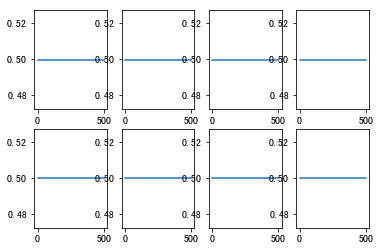

In [134]:
# Vilizating the data
for i in range(1,len(losses_tf)+1):
    plt.subplot(2,4,i)
    plt.plot(range(len(losses_tf[i-1])), losses_tf[i-1])
plt.show()

## Observe the effect of iteration_num on the test accuracy